# LCP Project: analysis of MAGIC04 dataset
First, we import the libraries

In [1]:
import numpy as np
import uncertainties as un
import matplotlib.pyplot as plt

import sympy as sp
from scipy.integrate import romb
from scipy.integrate import simpson

# Part 7: Calculation of the observation time
Assuming that the telescope has a collection area of 10^9 cm^2 and that we are observing gamma rays between 50 GeV and 50 TeV, to what observation time does this measurement corresponds? (assume here the Crab spectrum measured by HEGRA [Aharonian, F. et al. 2000])

To calculate the observation time corresponding to the Cherenkov telescope measurement, we use the Crab Nebula spectrum measured by HEGRA. Then, converting the telescope's collection area to square meters ( $A = 10^9 \, \text{cm}^2 $), we can determine
the event rate by integrating the flux over the energy range from **50 GeV to 50 TeV**:

$$
R = A \cdot J_{\gamma} =  A \int_{0.05 \, TeV}^{50 \, TeV} \frac{dJ_{\gamma}}{dE} dE
$$

This integration provides the **event rate in photons per second**. Given the total number of recorded events $n_\gamma$, we can then calculate the **observation time** by dividing the number of events by the event rate:

$$
\Delta t = \frac{n_{\gamma}}{R}
$$

In [2]:
# Constants
A = 10**9 * 1e-4  # collection area in m^2
E0 = 1.0          # TeV
Emin = 0.05       # TeV = 50 GeV
Emax = 50         # TeV
n_gamma, sigma_n_gamma =  4431, 43    # number of true gamma events

# Constants for the first integral
alpha1, alpha1_err = 2.59, 0.03
c1, c1_err = 2.79e-7, 0.02e-7

# Constants for the second integral
c2, c2_err = 2.67e-7, 0.01e-7
alpha2, alpha2_err = 2.47, 0.1
beta, beta_err = -0.11, 0.1

Primo integrale con errore dato da derivate parziali

## First integral
According to the study by **Aharonian et al. (2000)**, the differential flux of gamma rays in the range of $1-20 \, \text{TeV}$ is given by:

$$
\frac{dJ_{\gamma}}{dE} = (2.79 \pm 0.02) \times 10^{-7} \left( \frac{E}{1 \, \text{TeV}} \right)^{(-2.59 \pm 0.03)} \, \text{ph} \, \text{m}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
$$
\frac{dJ_{\gamma}}{dE} = c_1 \cdot \left( \frac{E}{E_0} \right)^{- \alpha_1} \, \text{ph} \, \text{m}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
with:
$$
c_1 = (2.79 \pm 0.02) \times 10^{-7} \, \text{TeV}^{-1} \, \text{m}^{-2} \, \text{s}^{-1}, E_0 = 1 \, \text{TeV}, \alpha_1 = 2.59 \pm 0.03
$$
so the integral will be:
$$
J_\gamma = \frac{E_0^{\alpha_1} \cdot c_1}{-\alpha_1 + 1} \cdot \left( E_{\text{max}}^{-\alpha_1 + 1} - E_{\text{min}}^{-\alpha_1 + 1} \right)
$$
with $E_{\text{min}} = 0.05 \, \text{TeV}, E_{\text{max}} = 50 \, \text{TeV} $

### Error Propagation

We have uncertainties in the following parameters:

$$
c_1 = (2.79 \pm 0.02) \times 10^{-7}
$$
$$
\alpha_1 = 2.59 \pm 0.03
$$

Using the general error propagation formula the total uncertainty in R:

$$
\sigma_R = \sqrt{ \left( \frac{\partial R}{\partial c_1} \sigma_{c_1} \right)^2 + \left( \frac{\partial R}{\partial \alpha_1} \sigma_{\alpha_1} \right)^2 }
$$

The error for the time will be:
$$
\sigma_t = t \sqrt{ \left( \frac{\sigma_{n_{\gamma}}}{n_{\gamma}} \right)^2 + \left( \frac{\sigma_R}{R} \right)^2 }
$$

In [3]:
def dJ_H(E, c1, alpha1):
    return c1 * np.power((E / E0), - alpha1)

def uncertainty(A, E0, Emin, Emax, c1, c1_err, alpha1, alpha1_err):
    #definisco i simboli
    c1_sym, alpha1_sym, Emin_sym, Emax_sym, E0_sym, A_sym = sp.symbols('c1 alpha1 Emin Emax E0 A')
    
    #definizione di R 
    R = (A_sym * c1_sym * (E0_sym**alpha1_sym) / (-alpha1_sym + 1)) * (Emax_sym**(-alpha1_sym + 1) - Emin_sym**(-alpha1_sym + 1))

    #calcolo le derivate parziali rispetto a c1 e alpha1
    dR_dc1 = sp.diff(R, c1_sym)
    dR_dalpha1 = sp.diff(R, alpha1_sym)
    
    #conversione a funzioni
    dR_dc1_func = sp.lambdify((A_sym, E0_sym, Emin_sym, Emax_sym, c1_sym, alpha1_sym), dR_dc1, 'numpy')
    dR_dalpha1_func = sp.lambdify((A_sym, E0_sym, Emin_sym, Emax_sym, c1_sym, alpha1_sym), dR_dalpha1, 'numpy')
    
    #calcolo il valore delle derivate e di R
    dR_dc1_val = dR_dc1_func(A, E0, Emin, Emax, c1, alpha1)
    dR_dalpha1_val = dR_dalpha1_func(A, E0, Emin, Emax, c1, alpha1)
    R_val = (A * c1 * (E0**alpha1) / (-alpha1 + 1)) * (Emax**(-alpha1 + 1) - Emin**(-alpha1 + 1))
    
    #incertezza totale su R
    sigma_R = np.sqrt((dR_dc1_val * c1_err) ** 2 + (dR_dalpha1_val * alpha1_err) ** 2)
    
    return R_val, sigma_R


#valore dell'errore su R
R_val, sigma_R = uncertainty(A, E0, Emin, Emax, c1, c1_err, alpha1, alpha1_err)
t1_H = (n_gamma / R_val) / 60
sigma_t1_H = t1_H * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_R/R_val)**2))

print("HEGRA with Power law")
print(f"t1_H = {t1_H:.1f} ± {sigma_t1_H:.1f} minutes")

HEGRA with Power law
t1_H = 35.9 ± 2.6 minutes


## Second integral
At low energies there is a slight flattening of the spectrum. A fit with a logarithmic steepening of the power law spectrum gives (according to the study by **Aharonian et al. (2000)**):
$$
\frac{dJ_{\gamma}}{dE} = (2.67 \pm 0.01) \times 10^{-7} \left( \frac{E}{1 \, \text{TeV}} \right)^{(-2.47 \pm 0.1) -(0.11 \pm 0.1) \, \log(E/E_0)} \, \text{ph} \, \text{m}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
$$
\frac{dJ_{\gamma}}{dE} = c_2 \cdot \left( \frac{E}{E_0} \right)^{- \alpha_2 + \beta \, \log(E/E_0)} \, \text{ph} \, \text{m}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
with:
$$
c_2 = (2.67 \pm 0.01) \times 10^{-7} \, \text{TeV}^{-1} \, \text{m}^{-2} \, \text{s}^{-1}, E_0 = 1 \, \text{TeV}, \alpha_2 = 2.47 \pm 0.1, \beta = -0.11 \pm 0.1
$$
Because of the logarithmic correction, it's impossible to integrate it analytically in a straightforward way. Hence, to calculate this integral, we use two numerical integration methods: Romberg integration and Simpson's Rule.

###  Romberg integration

In [4]:
E_values = np.linspace(Emin, Emax, 2**10+1)
dE = np.abs(E_values[0] - E_values[1])

def dJ_Romb_H(E, c2, alpha2, beta):
    return c2 * (E / E0) ** (-alpha2 + beta * np.log(E / E0))

J_gamma_values = dJ_Romb_H(E_values, c2, alpha2, beta)
J_gamma = romb(J_gamma_values, dx = dE)

R = A * J_gamma

def partial_derivatives2():
    dJ_dc2_values = dJ_Romb_H(E_values, c2, alpha2, beta) / c2
    dJ_dc2 = romb(dJ_dc2_values, dx=dE)
    
    dJ_dalpha2_values = -dJ_Romb_H(E_values, c2, alpha2, beta) * np.log(E_values / E0)
    dJ_dalpha2 = romb(dJ_dalpha2_values, dx=dE)

    dJ_dbeta_values = -dJ_Romb_H(E_values, c2, alpha2, beta) * (np.log(E_values / E0))**2
    dJ_dbeta = romb(dJ_dbeta_values, dx=dE)

    return dJ_dc2, dJ_dalpha2, dJ_dbeta

dJ_dc2, dJ_dalpha2, dJ_dbeta = partial_derivatives2()

sigma_J = np.sqrt(
    (dJ_dc2 * c2_err) ** 2 +
    (dJ_dalpha2 * alpha2_err) ** 2 +
    (dJ_dbeta * beta_err) ** 2
)

sigma_R = A * sigma_J

t2_Romb_H = (n_gamma / R)
sigma_t2_Romb_H = t2_Romb_H * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_R/R)**2))

print("HEGRA with Log-parabola fit using Romberg integration")
print(f"t2_Romb_H = {t2_Romb_H/60:.2f} +- {sigma_t2_Romb_H/60:.2f} minutes")

HEGRA with Log-parabola fit using Romberg integration
t2_Romb_H = 89.31 +- 51.33 minutes


#### Romberg with Monte Carlo error - non lo mettiamo

In [5]:
# Monte Carlo error

E_values = np.linspace(Emin, Emax, 2**10+1)
dE = np.abs(E_values[0] - E_values[1])

def dJ_gamma2(E, c2, alpha2, beta):
    return c2 * (E / E0) ** (-alpha2 + beta * np.log(E))

def R(c2, alpha2, beta):
    J_gamma_values = dJ_gamma2(E_values, c2, alpha2, beta)
    J_gamma = romb(J_gamma_values, dx = dE)
    return A * J_gamma

N = 10000
c2_mc = np.random.normal(c2, c2_err, N)
alpha2_mc = np.random.normal(alpha2, alpha2_err, N)
beta_mc = np.random.normal(beta, beta_err, N)

R_mc = np.array([R(c2, alpha2, beta) for c2, alpha2, beta in zip(c2_mc, alpha2_mc, beta_mc)])

#calcolo valor medio e errore di R
R_mean = np.mean(R_mc)
R_std = np.std(R_mc)  #std di R (distribuzione), non R_medio, quindi non va np.sqrt(N)

#propago su t
t2 = (n_gamma / R_mean)/60
sigma_t2 = t2 * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (R_std/R_mean)**2))

print(f"t2 = {t2:.2f} +- {sigma_t2:.2f} minutes")

t2 = 71.58 +- 52.67 minutes


#### using .quad - non lo mettiamo

In [6]:
from scipy.integrate import quad

#definisco l'integranda
def dJ_gamma(E, c2, alpha2, beta):
    return c2 * (E / E0) ** (-alpha2 + beta * np.log(E))

#definisco R
def R(c2, alpha2, beta):
    integral, _ = quad(dJ_gamma, Emin, Emax, args=(c2, alpha2, beta))
    return A * integral

#Monte Carlo for the error
N = 10000
c2_mc = np.random.normal(c2, c2_err, N)
alpha2_mc = np.random.normal(alpha2, alpha2_err, N)
beta_mc = np.random.normal(beta, beta_err, N)

R_mc = np.array([R(c2, alpha2, beta) for c2, alpha2, beta in zip(c2_mc, alpha2_mc, beta_mc)])

#calcolo valor medio e errore di R
R_mean = np.mean(R_mc)
R_std = np.std(R_mc)

#propago su t
t2 = (n_gamma / R_mean)/60
sigma_t2 = t2 * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (R_std/R_mean)**2))

print(f"t2 = {t2:.2f} +- {sigma_t2:.2f} minutes")

t2 = 74.16 +- 52.14 minutes


### Simpson's Rule

The trapezoidal rule estimates the area under a curve by approximating the curve with straight-line segments. We can often get a
better result if we approximate the function instead with curves of some kind, Simpson’s rule does exactly this, using quadratic curves.

In [7]:
n = int(10e6)
E_values = np.linspace(Emin, Emax, n+1)

def dJ_Simp_H(E, c2, alpha2, beta):
    return c2 * (E / E0) ** (-alpha2 + beta * np.log(E))

J_gamma_values = dJ_Simp_H(E_values, c2, alpha2, beta)
J_gamma = simpson(J_gamma_values, E_values)

R = A * J_gamma

def partial_derivatives():
    dJ_dc2_values = dJ_Simp_H(E_values, c2, alpha2, beta)  / c2
    dJ_dc2 = simpson(dJ_dc2_values, E_values)
    
    dJ_dalpha2_values = - dJ_Simp_H(E_values, c2, alpha2, beta) * np.log(E_values / E0)
    dJ_dalpha2 = simpson(dJ_dalpha2_values, E_values)
    
    dJ_dbeta_values = -dJ_Simp_H(E_values, c2, alpha2, beta) * np.log(E_values/E0) * np.log(E_values)
    dJ_dbeta = simpson(dJ_dbeta_values, E_values)

    return dJ_dc2, dJ_dalpha2, dJ_dbeta

dJ_dc2, dJ_dalpha2, dJ_dbeta = partial_derivatives()

sigma_J = np.sqrt(
    (dJ_dc2 * c2_err) ** 2 +
    (dJ_dalpha2 * alpha2_err) ** 2 +
    (dJ_dbeta * beta_err) ** 2
)

sigma_R = R * (sigma_J / J_gamma)

t2_Simp_H = (n_gamma / R) /60
sigma_t2_Simp_H = t2_Simp_H * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_R/R)**2))

print("HEGRA with Log-parabola fit using Simpson's Rule")
print(f"t2_Simp_H = {t2_Simp_H:.2f} +- {sigma_t2_Simp_H:.2f} minutes")

HEGRA with Log-parabola fit using Simpson's Rule
t2_Simp_H = 90.94 +- 50.54 minutes


#### Simpson with Monte Carlo error - non lo mettiamo

In [8]:
# Monte Carlo error
n = int(10e5)
E_values = np.linspace(Emin, Emax, n+1)

def dJ_gamma2(E, c2, alpha2, beta):
    return c2 * (E / E0) ** (-alpha2 + beta * np.log(E))

def R(c2, alpha2, beta):
    J_gamma_values = dJ_gamma2(E_values, c2, alpha2, beta)
    J_gamma = simpson(J_gamma_values, E_values)
    return A * J_gamma

N = 100
c2_mc = np.random.normal(c2, c2_err, N)
alpha2_mc = np.random.normal(alpha2, alpha2_err, N)
beta_mc = np.random.normal(beta, beta_err, N)

R_mc = np.array([R(c2, alpha2, beta) for c2, alpha2, beta in zip(c2_mc, alpha2_mc, beta_mc)])

#calcolo valor medio e errore di R
R_mean = np.mean(R_mc)
R_std = np.std(R_mc)  #std di R (distribuzione), non R_medio, quindi non va np.sqrt(N)

#propago su t
t2 = (n_gamma / R_mean)/60
sigma_t2 = t2 * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (R_std/R_mean)**2))

print(f"t2 = {t2:.2f} +- {sigma_t2:.2f} minutes")

t2 = 76.87 +- 44.15 minutes


### Monte Carlo

In [9]:
import numpy as np

# Function definition
def dJ_MC_H(E, c2, alpha2, beta):
    return c2 * (E / E0) ** (-alpha2 + beta * np.log(E))


n = int(10e5)
E_values = np.linspace(Emin, Emax, n+1)
y_max = np.max(dJ_MC_H(E_values, c2, alpha2, beta))


N = int(10e6)
E_samples = np.random.uniform(Emin, Emax, N)
y_samples = np.random.uniform(0, y_max, N)
f_values = dJ_MC_H(E_samples, c2, alpha2, beta)

count = np.sum(y_samples < f_values)
I = (Emax - Emin) * y_max * (count / N)

p = count / N
sigma_I = I * np.sqrt((1 - p) / (p * N))  #binomial proportion error

t2_MC_H = n_gamma / (A * I) / 60
sigma_t2_MC_H = t2_MC_H * np.sqrt((sigma_n_gamma / n_gamma) ** 2 + (sigma_I / I) ** 2)

print("HEGRA with Log-parabola fit using Monte Carlo")
print(f"t2_MC_H = {t2_MC_H:.2f} ± {sigma_t2_MC_H:.2f} minutes")

HEGRA with Log-parabola fit using Monte Carlo
t2_MC_H = 91.63 ± 1.28 minutes


# Part 8: Do the same using the MAGIC measured spectrum of the Crab Nebula [Aleksic, J. et al. 2015]

In [10]:
# Constants
A = 10**9 # collection area in cm^2
E0 = 1.0  # TeV
Emin = 0.05  # TeV = 50 GeV
Emax = 50  # TeV
n_gamma, sigma_n_gamma = 4431, 43

# Constants for the first integral
f0, f0_err = 3.80e-11, 0.11e-11
alpha, alpha_err = 2.21, 0.02
Ec, Ec_err = 6.0, 0.6

# Constants for the second integral
f02, f02_err = 3.23e-11, 0.03e-11
alpha2, alpha2_err = 2.47, 0.01
beta2, beta2_err = -0.24, 0.01

## First ingtegral: exponential cut off
occhio da qui i flussi in cm^-2 non più m^-2

power law with an exponential cut off:
$$
\frac{dJ_{\gamma}}{dE} = f_0 \cdot \left( \frac{E}{E_0} \right)^{- \alpha} e^{-E/E_C} \, \text{ph} \, \text{cm}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
$$
f_0 = (3.80 \pm 0.11) \times 10^{-11} \, \text{TeV}^{-1} \, \text{cm}^{-2} \, \text{s}^{-1}, \alpha = 2.21 \pm 0.02, E_C = (6.0 \pm 0.6) \, \text{TeV}, E_0 = 1 \, \text{TeV}
$$

### Simpson's Rule

In [11]:
# error with partial derivatives

n = int(10e5)
E_values = np.linspace(Emin, Emax, n+1)

def dJ_Simp_M(E, f0, alpha, Ec):
    return f0 * (E / E0) ** (- alpha) * np.exp(- E / Ec)

J_gamma_values = dJ_Simp_M(E_values, f0, alpha, Ec)
J_gamma = simpson(J_gamma_values, E_values)

R = A * J_gamma

def partial_derivatives():
    dJ_df0_values = dJ_Simp_M(E_values, f0, alpha, Ec) / f0
    dJ_df0 = simpson(dJ_df0_values, E_values)
    
    dJ_dalpha_values = - dJ_Simp_M(E_values, f0, alpha, Ec) * np.log(E_values / E0)
    dJ_dalpha = simpson(dJ_dalpha_values, E_values)
    
    dJ_dEc_values = -dJ_Simp_M(E_values, f0, alpha, Ec) * (E_values / (Ec**2))
    dJ_dEc = simpson(dJ_dEc_values, E_values)

    return dJ_df0, dJ_dalpha, dJ_dEc

dJ_df0, dJ_dalpha, dJ_dEc = partial_derivatives()

sigma_J = np.sqrt(
    (dJ_df0 * f0_err) ** 2 +
    (dJ_dalpha * alpha_err) ** 2 +
    (dJ_dEc * Ec_err) ** 2
)

sigma_R = (R * sigma_J) / J_gamma

t1_Simp_M = (n_gamma / R)/60
sigma_t1_Simp_M = t1_Simp_M * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_R/R)**2))

print("MAGIC Power law with cutoff using Simpson's Rule")
print(f"t1_Simp_M = {t1_Simp_M:.2f} +- {sigma_t1_Simp_M:.2f} minutes")

MAGIC Power law with cutoff using Simpson's Rule
t1_Simp_M = 64.68 +- 3.48 minutes


### Simpson's Rule with Monte Carlo error - non lo mettiamo

In [12]:
# Monte Carlo error

n = int(10e5)
E_values = np.linspace(Emin, Emax, n+1)

def dJ_gamma2(E, f0, alpha, Ec):
    return f0 * (E / E0) ** (- alpha) * np.exp(- E / Ec)

def R(f0, alpha, Ec):
    J_gamma_values = dJ_gamma2(E_values, f0, alpha, Ec)
    J_gamma = simpson(J_gamma_values, E_values)
    return A * J_gamma

N = 100
f0_mc = np.random.normal(f0, f0_err, N)
alpha_mc = np.random.normal(alpha, alpha_err, N)
Ec_mc = np.random.normal(Ec, Ec_err, N)

R_mc = np.array([R(f0, alpha, Ec) for f0, alpha, Ec in zip(f0_mc, alpha_mc, Ec_mc)])

#calcolo valor medio e errore di R
R_mean = np.mean(R_mc)
R_std = np.std(R_mc)  #std di R (distribuzione), non R_medio, quindi non va np.sqrt(N)

#propago su t
t2 = (n_gamma / R_mean)/60
sigma_t2 = t2 * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (R_std/R_mean)**2))

print(f"t2 = {t2:.2f} +- {sigma_t2:.2f} minutes")

t2 = 64.77 +- 3.34 minutes


### Monte Carlo

In [13]:
# Function definition
def dJ1_MC_M(E, f0, alpha, Ec):
    return f0 * (E / E0) ** (- alpha) * np.exp(- E / Ec)


n = int(10e5)
E_values = np.linspace(Emin, Emax, n+1)
y_max = np.max(dJ1_MC_M(E_values, f0, alpha, Ec))


N = int(10e6)
E_samples = np.random.uniform(Emin, Emax, N)
y_samples = np.random.uniform(0, y_max, N)
f_values = dJ1_MC_M(E_samples, f0, alpha, Ec)


count = np.sum(y_samples < f_values)
I = (Emax - Emin) * y_max * (count / N)
p = count / N
sigma_I = I * np.sqrt((1 - p) / (p * N)) 

t1_MC_M = n_gamma / (A * I) / 60
sigma_t1_MC_M = t1_MC_M * np.sqrt((sigma_n_gamma / n_gamma) ** 2 + (sigma_I / I) ** 2)

print('MAGIC Power law with cutoff using Monte Carlo')
print(f"t1_MC_M = {t1_MC_M:.2f} ± {sigma_t1_MC_M:.2f} minutes")

MAGIC Power law with cutoff using Monte Carlo
t1_MC_M = 64.65 ± 0.95 minutes


## Second integral (Log-parabola)

$$
\frac{dJ_{\gamma}}{dE} = f_0 \cdot \left( \frac{E}{E_0} \right)^{- \alpha + \beta \, \log(E / E_0)} \, \text{ph} \, \text{cm}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
$$
f_0 = (3.23 \pm 0.03) \times 10^{-11} \, \text{TeV}^{-1} \, \text{cm}^{-2} \, \text{s}^{-1}, \alpha = 2.47 \pm 0.01, \beta = -0.24 \pm 0.01, E_0 = 1 \, \text{TeV}
$$

### Simpson's Rule

In [14]:
# error with partial derivatives

n = int(10e5)
E_values = np.linspace(Emin, Emax, n+1)

def dJ_Simp_M(E, f02, alpha2, beta2):
    return f02 * (E / E0) ** (- alpha2 + beta2 * np.log(E / E0))

J_gamma_values = dJ_Simp_M(E_values, f02, alpha2, beta2)
J_gamma = simpson(J_gamma_values, E_values)

R = A * J_gamma

def partial_derivatives():
    dJ_df02_values = dJ_Simp_M(E_values, f02, alpha2, beta2) / f02
    dJ_df02 = simpson(dJ_df02_values, E_values)
    
    dJ_dalpha2_values = - dJ_Simp_M(E_values, f02, alpha2, beta2) * np.log(E_values / E0)
    dJ_dalpha2 = simpson(dJ_dalpha2_values, E_values)
    
    dJ_dbeta2_values = -dJ_Simp_M(E_values, f02, alpha2, beta2) * (np.log(E_values / E0))**2
    dJ_dbeta2 = simpson(dJ_dbeta2_values, E_values)

    return dJ_df02, dJ_dalpha2, dJ_dbeta2

dJ_df02, dJ_dalpha2, dJ_dbeta2 = partial_derivatives()

sigma_J = np.sqrt(
    (dJ_df02 * f02_err) ** 2 +
    (dJ_dalpha2 * alpha2_err) ** 2 +
    (dJ_dbeta2 * beta2_err) ** 2
)

sigma_R = (R * sigma_J) / J_gamma

t2_Simp_M = (n_gamma / R)/60
sigma_t2_Simp_M = t2_Simp_M * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_R/R)**2))

print("MAGIC with Log-parabola fit using Simpson's Rule")
print(f"t2_Simp_M = {t2_Simp_M:.2f} +- {sigma_t2_Simp_M:.2f} minutes")

MAGIC with Log-parabola fit using Simpson's Rule
t2_Simp_M = 138.19 +- 6.65 minutes


### Simpson's Rule with Monte Carlo error - non lo mettiamo

In [15]:
# Monte Carlo error

n = int(10e5)
E_values = np.linspace(Emin, Emax, n+1)

def dJ_gamma2(E, f02, alpha2, beta2):
    return f02 * (E / E0) ** (- alpha2 + beta2 * np.log(E / E0))

def R(f02, alpha2, beta2):
    J_gamma_values = dJ_gamma2(E_values, f02, alpha2, beta2)
    J_gamma = simpson(J_gamma_values, E_values)
    return A * J_gamma

N = 100
f02_mc = np.random.normal(f02, f02_err, N)
alpha2_mc = np.random.normal(alpha2, alpha2_err, N)
beta2_mc = np.random.normal(beta2, beta2_err, N)

R_mc = np.array([R(f02, alpha2, beta2) for f02, alpha2, beta2 in zip(f02_mc, alpha2_mc, beta2_mc)])

#calcolo valor medio e errore di R
R_mean = np.mean(R_mc)
R_std = np.std(R_mc)  #std di R (distribuzione), non R_medio, quindi non va np.sqrt(N)

#propago su t
t2 = (n_gamma / R_mean)/60
sigma_t2 = t2 * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (R_std/R_mean)**2))

print(f"t2 = {t2:.2f} +- {sigma_t2:.2f} minutes")

t2 = 138.19 +- 7.69 minutes


### Monte Carlo

In [16]:
# Function definition
def dJ2_MC_M(E, f02, alpha2, beta2):
    return f02 * (E / E0) ** (- alpha2 + beta2 * np.log(E / E0))


n = int(10e5)
E_values = np.linspace(Emin, Emax, n+1)
y_max = np.max(dJ2_MC_M(E_values, f02, alpha2, beta2))


N = int(10e6)
E_samples = np.random.uniform(Emin, Emax, N)
y_samples = np.random.uniform(0, y_max, N)
f_values = dJ2_MC_M(E_samples, f02, alpha2, beta2)


count = np.sum(y_samples < f_values)
I = (Emax - Emin) * y_max * (count / N)
p = count / N
sigma_I = I * np.sqrt((1 - p) / (p * N)) 

t2_MC_M = n_gamma / (A * I) / 60
sigma_t2_MC_M = t2_MC_M * np.sqrt((sigma_n_gamma / n_gamma) ** 2 + (sigma_I / I) ** 2)

print('MAGIC with Log-parabola fit')
print(f"t2_MC_M = {t2_MC_M:.2f} ± {sigma_t2_MC_M:.2f} minutes")

MAGIC with Log-parabola fit
t2_MC_M = 139.06 ± 1.71 minutes


# Part 9: Plot both spectra and answer if the difference in the observation time that you are obtaining goes in the direction of the difference in the spectra that you are plotting

Gli errori sullo spettro di energia dato da HEGRA sono più grandi (due ordini di grandezza) di quelli dati da MAGIC a causa degli errori su $ \alpha $ e $ \beta $. Infatti nel caso di HEGRA sono dell'ordine di $ 10^{-1} $, nel caso di MAGIC $ 10^{-2} $.

Nel grafico mostriamo i risultati ottenuti con Monte Carlo (che piace tanto al prof e sono i migliori, almeno per il caso di HEGRA)

The MAGIC spectrum is steeper (flux decreases faster with energy), this means that detecting the same number of photons requires more observation time because fewer high-energy photons are detected.
If a spectrum is flatter (flux decreases slower), then the same number of photons can be collected in less time.

The log-parabola fit of MAGIC might indicate a spectral curvature that HEGRA could not detect due to lower sensitivity.
If MAGIC's observation time is longer, this suggests that its spectrum is steeper than HEGRA’s → meaning a different emission process or improved precision in measurement.

If the MAGIC spectrum is steeper than HEGRA, MAGIC should need more observation time.
If MAGIC shows a flatter or higher flux at high energies, then it should require less observation time than HEGRA.
The agreement between these trends tells us if the spectral changes are real (e.g., due to new physics, better sensitivity) or if they are just an effect of observation conditions.

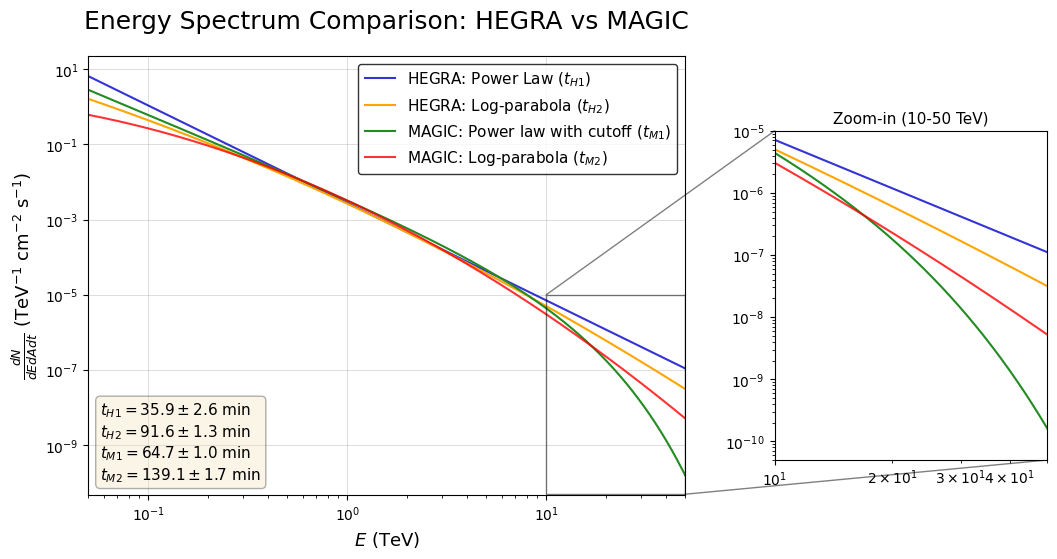

In [121]:
E = np.linspace(Emin, Emax, 2**20+1)

fig, ax = plt.subplots(figsize=(7.7, 5.7))

ax.plot(E, 1e8 * dJ_H(E, (c1 * 1e-4), alpha1), color='mediumblue', alpha=0.8, label='HEGRA: Power Law ($t_{H1}$)')
ax.plot(E, 1e8 * dJ_MC_H(E, (c2 * 1e-4), alpha2, beta), color='orange', label='HEGRA: Log-parabola ($t_{H2}$)')
ax.plot(E, 1e8 * dJ1_MC_M(E, f0, alpha, Ec), color='forestgreen', label='MAGIC: Power law with cutoff ($t_{M1}$)')
ax.plot(E, 1e8 * dJ2_MC_M(E, f02, alpha2, beta2), color='red', alpha=0.8, label='MAGIC: Log-parabola ($t_{M2}$)')
ax.semilogx()
ax.semilogy()
ax.set_xlim([Emin, Emax])
ax.set_xlabel(r'$E$ (TeV)', fontsize=13)
ax.set_ylabel(r'$\frac{dN}{dE dA dt}$ (TeV$^{-1}$ cm$^{-2}$ s$^{-1}$)', fontsize=13)
ax.set_title('Energy Spectrum Comparison: HEGRA vs MAGIC', fontsize=18, pad=20)
ax.legend(loc='best', fontsize=11, frameon=True, edgecolor='black')
ax.grid(True, linestyle='-', linewidth=0.6, alpha=0.5)

#Zoom-in
x1, x2, y1, y2 = 1e1, 5e1, 5e-11, 1e-5

axins = ax.inset_axes([1.15, 0.08, 0.457, 0.75])
axins.plot(E, 1e8 * dJ_H(E, (c1 * 1e-4), alpha1), color='mediumblue', alpha=0.8)
axins.plot(E, 1e8 * dJ_MC_H(E, (c2 * 1e-4), alpha2, beta), color='orange')
axins.plot(E, 1e8 * dJ1_MC_M(E, f0, alpha, Ec), color='forestgreen')
axins.plot(E, 1e8 * dJ2_MC_M(E, f02, alpha2, beta2), color='red', alpha=0.8)
axins.semilogx()
axins.semilogy()
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_title('Zoom-in (10-50 TeV)', fontsize=11)

ax.indicate_inset_zoom(axins, edgecolor="black")

#Results
textstr = (
    r'$t_{H1} = %.1f \pm %.1f$ min' % (t1_H, sigma_t1_H) + '\n' +
    r'$t_{H2} = %.1f \pm %.1f$ min' % (t2_MC_H, sigma_t2_MC_H) + '\n' +
    r'$t_{M1} = %.1f \pm %.1f$ min' % (t1_MC_M, sigma_t1_MC_M) + '\n' +
    r'$t_{M2} = %.1f \pm %.1f$ min' % (t2_MC_M, sigma_t2_MC_M)
)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
ax.text(0.02, 0.215, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.show()